Basic imports. Because I'm running this on an M1 and there are weird conflicts with standard intel processors. I'm using tensorflow-metal and a virtual conda environment. This is overkill, but makes for good practice!

In [10]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

Gets path for all future uses.

In [11]:
images_path = os.getcwd()
print(images_path)

/Users/Alex/Desktop/Image-Classification


Recreates the "Other-Usable" directory because we want to create an "Other" file effectively and play around with its construction. Having to delete said file everytime is burdensome.

In [12]:
def refresh_dir(path, name):
    try:
        shutil.rmtree(path + name)
    except Exception as e:
        print("Couldn't remove " + str(path) + str(name))
    finally:
        os.mkdir(path + name)

refresh_directories = ["/Images-Using/Other-Usable"]
for ref_dir in refresh_directories:
    refresh_dir(images_path, ref_dir)

Combines every photo from all "Other" categories and gives them a unique name. All photos are put into the new "Other-Usable" directory.

In [13]:
def do_splits(src, directory_given, class_idx):
    directory = images_path + directory_given
    allFileNames = os.listdir(directory)
    allFileNames = [src + directory_given + '/' + name for name in allFileNames]
    directory = "/Images-Using/Other-Usable"

    idx = 0
    for name in allFileNames:
        failed_naming = True
        while failed_naming:
            try:
                shutil.copy(name, src + directory)
                os.rename(src + directory + '/' + name.rsplit('/', 1)[-1],
                          src + directory + '/' + str(class_idx) + '-' + str(idx) + name.rsplit('/', 1)[-1])
                failed_naming = False
            except:
                idx += 1
            idx += 1

classes = ["/Human", "/Nature-Background", "/Text", "/Dogs", "/Cats", "/Hamsters", "/Suggestively-Sexual",
           "/Suggestively-Violent", "/Abstract-Background", "/Empty-Cages", "/Bunny-Drawings"]
class_idx = 0
for class_dir in classes:
    do_splits(images_path, "/Other-Directory" + class_dir, class_idx)
    class_idx += 1

We standardize the size of the input and also how many inputs are fed in at once. I'm training on a good GPU and can use more than 32 images at once in my batch size, but because of the limited number of samples I'm afraid that I may overfit my data faster. Next we set our data into training and validation sets. We will not be making a testing set for this case because as the results show, this model isn't worth testing as won't be as good as the next iteration.

In [14]:
batch_size = 32
img_height = 180
img_width = 180

split_directory = images_path + "/Images-Using"

train_ds = tf.keras.utils.image_dataset_from_directory(
    split_directory,
    validation_split=0.2,
    subset="training",
    seed=321,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

validation_ds = tf.keras.utils.image_dataset_from_directory(
    split_directory,
    validation_split=0.2,
    subset="validation",
    seed=321,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 1222 files belonging to 2 classes.
Using 978 files for training.
Found 1222 files belonging to 2 classes.
Using 244 files for validation.


We will now use buffered prefetching. The I/O will be constantly bringing data in from the disk to usable memory, but this process is really slow. Grabbing from the I/O before it's needed will help resolve this data transfer bottleneck. When running multiple epochs the data will be held in memory if possible and not deload.

In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)

We create our model by first normalizing input through our "layers.Rescaling" layer. Next we add convolutional layers that look over the image three times until a dense layer acts as a classifying agent. The layers use relu for efficient backpropagation.
The model is then compiled and prints a sumamry of the model architecture.

In [16]:
num_classes = 2

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 64)       

Now we finally train the model. We selected 10 epochs because even with 10 we get overfitting on our small dataset.

In [17]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=epochs
)

Epoch 1/10


2022-10-02 17:38:36.393510: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - 2s 41ms/step - loss: 0.8548 - accuracy: 0.5215 - val_loss: 0.6741 - val_accuracy: 0.5902
Epoch 2/10


2022-10-02 17:38:37.728950: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - 1s 33ms/step - loss: 0.6619 - accuracy: 0.5930 - val_loss: 0.6750 - val_accuracy: 0.5574
Epoch 3/10
31/31 [==============================] - 1s 33ms/step - loss: 0.6448 - accuracy: 0.6125 - val_loss: 0.6472 - val_accuracy: 0.6148
Epoch 4/10
31/31 [==============================] - 1s 33ms/step - loss: 0.6092 - accuracy: 0.6564 - val_loss: 0.6151 - val_accuracy: 0.6721
Epoch 5/10
31/31 [==============================] - 1s 33ms/step - loss: 0.5957 - accuracy: 0.6687 - val_loss: 0.6466 - val_accuracy: 0.6148
Epoch 6/10
31/31 [==============================] - 1s 33ms/step - loss: 0.5683 - accuracy: 0.7025 - val_loss: 0.6022 - val_accuracy: 0.7049
Epoch 7/10
31/31 [==============================] - 1s 33ms/step - loss: 0.4868 - accuracy: 0.7740 - val_loss: 0.7828 - val_accuracy: 0.5738
Epoch 8/10
31/31 [==============================] - 1s 33ms/step - loss: 0.4553 - accuracy: 0.7720 - val_loss: 0.5629 - val_accuracy: 0.7090
Epoch 9/10
31/31 [======

As we see, overfitting occurs after the 2nd or 3rd epoch where training accuracy overtakes validation accuracy. And as training loss becomes lower, the validation loss starts to increase after the 4th epoch, showing definite signs of overfitting.

The results aren't stellar. We're not going to use dropout or data augmentation as a way to better generalize the model for now, as the minimal benefits aren't worth it. What we'll do instead is focus on transfer learning and see what gains can be made there.

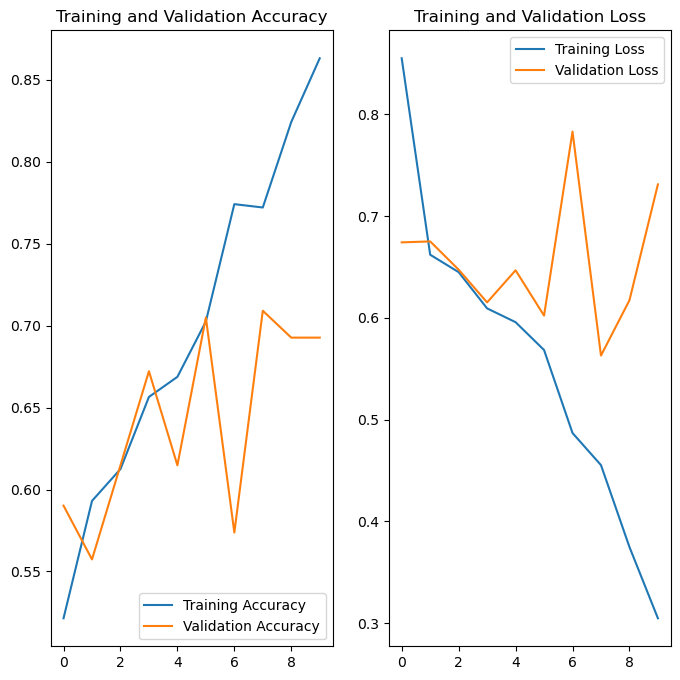

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()